In [1]:
import numpy as np # linear algebra
import pandas as pd 
column_names = ['male', 'age', 'debt', 'married', 'bankcustomer', 'educationlevel', 'ethnicity', 'yearsemployed',
               'priordefault', 'employed', 'creditscore', 'driverslicense', 'citizen', 'zip', 'income', 'approved']

data = pd.read_csv('data/crx.data', header=None,  names=column_names)
data.reset_index(drop=True, inplace=True) 


data = data.dropna(how = 'all')
data = data[data.age != '?']

print(data.head())

from sklearn import preprocessing
for feat in ['male', 'married','bankcustomer', 'educationlevel', 'ethnicity','priordefault', 'employed', 'driverslicense', 'citizen', 'zip', 'approved']:
    data[feat] = preprocessing.LabelEncoder().fit_transform(data[feat])


#####################################################
#### For this experiment, we uniquely drop the default variable (prior default)
###################################################
#data = data.drop(['educationlevel'], axis=1)
    
print(len(data))

from pycausal.pycausal import pycausal as pc
pc = pc()
pc.start_vm()

from pycausal import prior as p
prior = p.knowledge(addtemporal = [['male', 'age','ethnicity'],[ 'debt', 'married', 'bankcustomer', 'educationlevel', 'yearsemployed',
                'employed', 'creditscore', 'driverslicense', 'citizen', 'zip', 'income'],['approved']])


from pycausal import search as s
tetrad = s.tetradrunner()
tetrad.run(algoId = 'fges', scoreId = 'cg-bic-score', dfs = data, priorKnowledge = prior,
           maxDegree = -1, faithfulnessAssumed = True, verbose = False)
tetrad.getEdges()

  male    age   debt married bankcustomer educationlevel ethnicity  \
0    b  30.83  0.000       u            g              w         v   
1    a  58.67  4.460       u            g              q         h   
2    a  24.50  0.500       u            g              q         h   
3    b  27.83  1.540       u            g              w         v   
4    b  20.17  5.625       u            g              w         v   

   yearsemployed priordefault employed  creditscore driverslicense citizen  \
0           1.25            t        t            1              f       g   
1           3.04            t        t            6              f       g   
2           1.50            t        f            0              f       g   
3           3.75            t        t            5              t       g   
4           1.71            t        f            0              f       s   

     zip  income approved  
0  00202       0        +  
1  00043     560        +  
2  00280     824        + 

['age --> yearsemployed',
 'priordefault --> age',
 'creditscore --> debt',
 'ethnicity --> age',
 'yearsemployed --> creditscore',
 'zip --> debt',
 'married --> approved',
 'yearsemployed --> debt',
 'employed --> creditscore',
 'bankcustomer --> approved',
 'employed --> approved',
 'priordefault --> yearsemployed',
 'bankcustomer --> employed',
 'bankcustomer --- married',
 'priordefault --> approved',
 'yearsemployed --> driverslicense',
 'citizen --> employed',
 'creditscore --> zip',
 'employed --> priordefault']

In [2]:
edges = []
for edge in tetrad.getEdges():
    edges.append(list([column_names.index(edge.split(' ')[0]), column_names.index(edge.split(' ')[-1])]))
print(edges )

[[1, 7], [8, 1], [10, 2], [6, 1], [7, 10], [13, 2], [3, 15], [7, 2], [9, 10], [4, 15], [9, 15], [8, 7], [4, 9], [4, 3], [8, 15], [7, 11], [12, 9], [10, 13], [9, 8]]


In [3]:
# Copy the above edge list 
column_names.index('male')

0

In [4]:
data.head()

,male,age,debt,married,bankcustomer,educationlevel,ethnicity,yearsemployed,priordefault,employed,creditscore,driverslicense,citizen,zip,income,approved
0,2,30.83,0.000,2,1,13,8,1.25,1,1,1,0,0,68,0,0
1,1,58.67,4.460,2,1,11,4,3.04,1,1,6,0,0,11,560,0
2,1,24.50,0.500,2,1,11,4,1.50,1,0,0,0,0,96,824,0
3,2,27.83,1.540,2,1,13,8,3.75,1,1,5,1,0,31,3,0
4,2,20.17,5.625,2,1,13,8,1.71,1,0,0,0,2,37,0,0


In [5]:
import numpy as np # linear algebra
import pandas as pd 
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score
from sklearn.neural_network import MLPClassifier
# from models.DECAF_credit import *
from sklearn.metrics import confusion_matrix
            
column_names = ['male', 'age', 'debt', 'married', 'bankcustomer', 'educationlevel', 'ethnicity', 'yearsemployed',
               'priordefault', 'employed', 'creditscore', 'driverslicense', 'citizen', 'zip', 'income', 'approved']

data = pd.read_csv('data/crx.data', header=None,  names=column_names)
print(data.head(5))
data.reset_index(drop=True, inplace=True) 
print(len(data))

data = data.dropna(how = 'all')

data = data[data.age != '?']
data.reset_index(drop=True, inplace = True)

print(len(data))

from sklearn import preprocessing
for feat in ['male', 'married','bankcustomer', 'educationlevel', 'ethnicity','priordefault', 'employed', 'driverslicense', 'citizen', 'zip', 'approved']:
    data[feat] = preprocessing.LabelEncoder().fit_transform(data[feat])

data['age'] = pd.to_numeric(data['age'],errors='coerce')

#####################################################
#### For this experiment, we uniquely drop the default variable (prior default)
###################################################
#data = data.drop(['priordefault'], axis=1)

# binarize the protected variable
data.loc[data['ethnicity'] <= 4, 'ethnicity'] = 0
data.loc[data['ethnicity'] > 4, 'ethnicity']= 1
data.loc[data['ethnicity'] == 1 , 'employed'] =  1

biased_data = data.copy()
biased_data.loc[biased_data['ethnicity'] == 1, 'approved'] = 0

thresh = 0.8

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(data)
data[data.columns] = scaler.fit_transform(data)
biased_data[biased_data.columns] = scaler.transform(biased_data)
print(biased_data.approved.value_counts(), biased_data.ethnicity.value_counts())

  male    age   debt married bankcustomer educationlevel ethnicity  \
0    b  30.83  0.000       u            g              w         v   
1    a  58.67  4.460       u            g              q         h   
2    a  24.50  0.500       u            g              q         h   
3    b  27.83  1.540       u            g              w         v   
4    b  20.17  5.625       u            g              w         v   

   yearsemployed priordefault employed  creditscore driverslicense citizen  \
0           1.25            t        t            1              f       g   
1           3.04            t        t            6              f       g   
2           1.50            t        f            0              f       g   
3           3.75            t        t            5              t       g   
4           1.71            t        f            0              f       s   

     zip  income approved  
0  00202       0        +  
1  00043     560        +  
2  00280     824        + 

In [6]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score
from sklearn.neural_network import MLPClassifier
from fairGAN_code.fairGAN import Medgan
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
# from DECAF.data import DataModule
import pickle


def train_fairgan(datapath):

    #data = np.load(datapath, allow_pickle = True)
    inputDim = data.shape[1]-1
    inputNum = data.shape[0]
    tf.reset_default_graph()
    
    mg = Medgan(dataType='count',
                inputDim=inputDim,
                embeddingDim=128,
                randomDim=128,
                generatorDims=(128,128),
                discriminatorDims=(256,128),
                compressDims=(),
                decompressDims=(),
                bnDecay=0.99,
                l2scale=0.001)

    model_file = ''
    out_file = 'fair'
    batch_size = 32
    
    mg.train(dataPath=datapath,
             modelPath=model_file,
             outPath=out_file,
             pretrainEpochs=200,
             nEpochs=50,
             discriminatorTrainPeriod=2,
             generatorTrainPeriod=1,
             pretrainBatchSize=batch_size,
             batchSize=batch_size,
             # protected = [6],
             saveMaxKeep=0)
    tf.reset_default_graph()
    
    return mg.generateData(nSamples=inputNum,
                        modelFile='fair-399',
                        batchSize=batch_size,
                        outFile=out_file)

In [9]:
def train_model(data, bias_dict = {}, surrogate = False):
    dm = DataModule(data.values)
    data_tensor = dm.setup()

    #dm = SyntheticDataModule()
    #data_tensor = dm.setup()
    #activation_layer = nn.ReLU(inplace=True) #nn.LeakyReLU(0.2, inplace=True)

    # Causal GAN
    #%% Import functions

    params = dict()
    params["iterations"] = 2000
    params["h_dim"] = 200
    params["z_dim"] = 10
    params["mb_size"] = 128
    params["lambda_gp"] = 10
    params["d_updates"] = 10

    max_epochs = (10 + 1) * 25 
    number_of_gpus = 0


    # Remove all the education level edges.#5
    biased_list =[[1, 7],  [7, 10], 
                  [8, 10], 
                  [2, 13], [9, 5], [9, 10], 
                  [7, 8], 
                  [12, 3], # Removed edge between age and ethnicity.
                  [9, 4], 
                  [8, 3], 
                  [6, 15], # Remove this for training purposes. 
                  [7, 11], [7, 15], [13, 3], [13, 14], [10, 2], [2, 14], 
                  [5, 3], [7, 2], [9, 15], [8, 2], [14, 3], [14, 15], [4, 3], [8, 15], 
                  [13, 11], [9, 12], [8, 9],
                 [6,9] # This is the edge from ethnicity to employed
                 ]
    
    
    biased_list =[[1, 7],  [7, 10], 
                  [8, 10], 
                  [2, 13],  [9, 10], 
                  [7, 8], 
                  [12, 3], # Removed edge between age and ethnicity.
                  [9, 4], 
                  [8, 3], 
                  [6, 15], # Remove this for training purposes. 
                  [7, 11], [7, 15], [13, 3], [13, 14], [10, 2], [2, 14], [7, 2], [9, 15], [8, 2], [14, 3], [14, 15], [4, 3], [8, 15], 
                  [13, 11], [9, 12], [8, 9],
                 [6,9] # This is the edge from ethnicity to employed
                 ]
    
    
    # model initialisation and train
    model = causal_gan(dm, dag_seed = biased_list,
               h_dim=200,
               lr=1e-3,
               batch_size=64,
               lambda_privacy=0,
               lambda_gp=10,
               d_updates=10,
               causal=True,
               alpha=2,
               rho=2,
               weight_decay=1e-2,
               grad_dag_loss=False,
               l1_g=0,
               l1_W=1e-4,
               p_gen=-0.2,
               use_mask=True,
              )
    print(model.hparams)
    trainer = pl.Trainer(gpus=number_of_gpus, max_epochs=max_epochs, progress_bar_refresh_rate=1, profiler = False)
    model.set_val_data(data_tensor)

    print("Training")
    trainer.fit(model, dm)
    synth_data = model.gen_synthetic(data_tensor, gen_order = model.get_gen_order(), biased_edges = bias_dict, surrogate = surrogate).detach().numpy()
    print(synth_data.shape)
    
    return synth_data



In [10]:
protected_idx = 6
# ADSGAN
#%% Import functions
# from models.adsgan import adsgan
# from models.gan import gan
# from models.pategan import pategan
# from models.vae import vae
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix

from metrics.combined import compute_metrics

params = dict()
params["iterations"] = 2000
params["h_dim"] = 200
params["z_dim"] = 10
params["mb_size"] = 128
params["lambda_gp"] = 10
params["d_updates"] = 10
params['lambda'] = 0

def view_stats_new(method_list, input_data, orig_data = [], protected = '', skip_synth = False, protected_idx = -1, runs =3, bias_dict = {}, remove_protected = False, surrogate = False):

    summary = ''
    
    samples = 5000
    # Note that for gender 0 is female, and 1 is male
    

    
    if not remove_protected:
        x_pos = orig_data[orig_data[p_attr] == 0].drop(['approved'], axis = 1)[:samples]
        y_pos = orig_data[orig_data[p_attr] == 0]['approved'][:samples]
        x_neg = orig_data[orig_data[p_attr] == 1].drop(['approved'], axis = 1)[:samples]
        y_neg = orig_data[orig_data[p_attr] == 1]['approved'][:samples]
        print(len(x_pos), len(y_pos), len(x_neg), len(y_neg))
    else:
        input_data = input_data.drop([protected], axis = 1)
        x_pos = orig_data[orig_data[p_attr] == 0].drop(['approved', protected], axis = 1)[:samples]
        y_pos = orig_data[orig_data[p_attr] == 0]['approved'][:samples]
        x_neg = orig_data[orig_data[p_attr] == 1].drop(['approved', protected], axis = 1)[:samples]
        y_neg = orig_data[orig_data[p_attr] == 1]['approved'][:samples]
        print(len(x_pos), len(y_pos), len(x_neg), len(y_neg))
        
    X_unbiased = pd.concat([x_pos, x_neg],axis=0).copy()
    y_unbiased  = pd.concat([y_pos, y_neg],axis=0).copy()
    
    for method in method_list:
        
        params['gen_model_name'] = method.replace('-pr', '')
        
        if method == 'adsgan':
            params['lambda'] = 0
        else:
            params['lambda'] = 1
            
            
        if method == 'vae':
            params["iterations"] = 1000
        else:
            params["iterations"] = 2000
        err = []
        feat_importance = []
        recall_ratio = []
        
        mutual_info = []
        precision = []
        recall = []
        density =[]
        coverage = []
        roc =[]
        
        for i in range(runs):
            
            if skip_synth:
                synth_data = input_data.values
            else:
                if method == 'fairgan':
                    # Need to swap 0 column with protected idx.
                    temp = input_data.copy()
                    popped = temp.pop('ethnicity')
                    temp.insert(0, 'ethnicity', popped)
                    
                    pickle.dump(temp.values, open( "adult.npy", "wb" ) )
                    synth_data, synth_data_z = train_fairgan('adult.npy')
            
                    # Have to swap columns back like so.... x[:,[2,1]] = x[:,[1,2]]
                    #synth_data[:,[0,6]] = synth_data[:,[6,0]]
                    
                    print("synth before:", synth_data.shape, synth_data_z.shape)
                    synth_data = np.insert(synth_data, 6, synth_data_z, axis=1)
                    print("synth after:", synth_data.shape)

                elif method == 'adsgan' or method == 'adsgan-pr':
                    synth_data = adsgan(input_data, params)
                elif method == 'gan' or method == 'wgan' or method == 'gan-pr' or method == 'wgan-pr':
                    synth_data = gan(input_data, params)
                elif method == 'vae':
                    synth_data = vae(input_data, params)
                else:
                    synth_data = train_model(input_data, bias_dict, surrogate = surrogate)

                                                     
            # This step is to ensure at least one sample there.
            pos_sample = input_data[input_data.approved == 0].iloc[0].values
            neg_sample = input_data[input_data.approved == 1].iloc[0].values
            synth_data = np.concatenate([synth_data, [pos_sample], [neg_sample]], axis = 0)        
            X = synth_data[:,:-1]

            #if remove_protected: 
            #    X = np.delete(synth_data, protected_idx, axis = 1)[:,:-1]
            
            y = np.round(synth_data[:, -1])

            mlp = MLPClassifier(random_state = i, max_iter = 100).fit(X, y)
            #mlp = LogisticRegression(random_state = i, max_iter = 100).fit(X, y)
                
            for X_unbiased, y_unbiased, _label in zip([x_pos, x_neg, pd.concat([x_pos, x_neg],axis=0).copy()], 
                                                      [y_pos, y_neg, pd.concat([y_pos, y_neg],axis=0).copy()],
                                                      ['pos', 'neg', 'both']):
                
                print("LOGGGING", len(X_unbiased), len(y_unbiased))
                if not remove_protected:
                    def compute_FTU(x):
                        x[p_attr] = 0
                        neg = mlp.predict(x)
                        x[p_attr] = 1
                        pos = mlp.predict(x)
                        return pos-neg
                    if _label == 'pos':
                        FTU = compute_FTU(x_pos)
                    elif _label == 'neg':
                        FTU = compute_FTU(x_neg)
                    else:
                        x_all = pd.concat([x_pos, x_neg],axis=0)
                        FTU = compute_FTU(x_all) 
                else:
                    FTU = 0 # by definition
                #print('FTU', FTU)
                pred_pos = mlp.predict(x_pos)
                pred_neg = mlp.predict(x_neg)
                if _label == 'pos':
                    DP = np.mean(pred_pos)
                elif _label =='neg':
                    DP = np.mean(pred_neg)
                else:
                    DP = np.mean(pred_pos)-np.mean(pred_neg)
                #print('DP', DP)

                CM = confusion_matrix(y_pos, mlp.predict(x_pos))
                TN = CM[0][0]
                FN = CM[1][0]
                TP = CM[1][1]
                FP = CM[0][1]

                tpr_pos = CM[1][1]/(CM[0][0]+CM[0][1])
                CM = confusion_matrix(y_neg, mlp.predict(x_neg))
                tpr_neg = CM[1][1]/(CM[1][1]+CM[0][1])

                roc.append(roc_auc_score(y_unbiased, mlp.predict_proba(X_unbiased)[:,1]))

                print(tpr_pos), print(tpr_neg)
                err.append(DP)#tpr_pos - tpr_neg)
                if True:
                    feat_importance.append(np.mean(FTU)) # BB 06/05 - just checking whether this leads to decent results.
                elif protected_idx >= 0:
                    feat_importance.append(mlp.coef_[0][protected_idx])

                else:
                    feat_importance.append(-1)

                print("Feature Importance = ", feat_importance)

                mutual_info.append(-1)


                if remove_protected:
                    results = compute_metrics(orig_data.drop([protected], axis = 1), synth_data,  which_metric = [['PRDC']], 
                                           wd_params = {},model = None,verbose = True)
                else:
                    #results = compute_metrics(orig_data.drop([protected], axis=1), np.delete(synth_data, protected_idx, 1),  which_metric = [['PRDC']], 
                    #                       wd_params = {},model = None,verbose = True)
                    

                    if _label == 'pos':
                        results = compute_metrics(pd.concat([X_unbiased, y_unbiased],axis=1), synth_data[synth_data[:,protected_idx].astype(bool)],  which_metric = [['PRDC']], 
                                           wd_params = {},model = None,verbose = True)
                    elif _label == 'neg':
                        print("Computing neg")
                        print( synth_data[1-synth_data[:,protected_idx].astype(bool)].shape)
                        results = compute_metrics(pd.concat([X_unbiased, y_unbiased],axis=1), synth_data[1-synth_data[:,protected_idx].astype(bool)],  which_metric = [['PRDC']], 
                                           wd_params = {},model = None,verbose = True)
                    else:
                        results = compute_metrics(pd.concat([X_unbiased, y_unbiased],axis=1), synth_data,  which_metric = [['PRDC']], 
                                           wd_params = {},model = None,verbose = True)
                precision.append(results['precision'])
                recall.append(results['recall'])
                density.append(results['density'])
                coverage.append(results['coverage'])

                # Writing to file
                with open("plots_surrogate_confounder_" + _label + '.csv', "a") as log:
                    # Writing data to a file
                    log.write(method +"," + str(bias) + "," + str(results['precision']) + ',' + str(results['recall']) + ',' + str(results['density']) + \
                              ',' + str(results['coverage']) + ',' + str(err[-1]) + ',' + str(feat_importance[-1]) + ',' + str(roc[-1]) + '\n')

        if skip_synth:
            print("no_synth", round(np.mean(err),3), round(np.std(err),3), 
              round(np.mean(feat_importance),3), round(np.std(feat_importance),3),
              round(np.mean(mutual_info),3), round(np.std(mutual_info),3)
             )
            break
        else:
            print(method, round(np.mean(err),3), round(np.std(err),3), 
              round(np.mean(feat_importance),3), round(np.std(feat_importance),3),
              round(np.mean(mutual_info),3), round(np.std(mutual_info),3)
             )

        #summary+= method + '&$' + str(round(np.mean(precision),3)) + '\pm' + str(round(np.std(precision),3)) + '$&$' + str(round(np.mean(recall),3)) + '\pm' + str(round(np.std(recall),3)) + \
        #         '$&$' + str(round(np.mean(density),3)) + '\pm' + str(round(np.std(density),3)) + '$&$' + str(round(np.mean(coverage),3)) + '\pm' + str(round(np.std(coverage),3)) + \
        #         '$&$' + str(round(np.mean(err),3)) + '\pm' + str(round(np.std(err),3)) + '$&$' + str(round(np.mean(mutual_info),3)) + '\pm' + str(round(np.std(mutual_info),3)) + '$\\\\\n'
        
        
        summary+= method + '&$' + str(round(np.mean(precision),3)) + '\pm' + str(round(np.std(precision),3)) + '$&$' + str(round(np.mean(recall),3)) + '\pm' + str(round(np.std(recall),3)) + \
                 '$&$' + str(round(np.mean(err),3)) + '\pm' + str(round(np.std(err),3)) + '$&$' + str(round(np.mean(feat_importance),3)) + '\pm' + str(round(np.std(feat_importance),3)) + \
                 '$&$' + str(round(np.mean(roc),3)) + '\pm' + str(round(np.std(roc),3)) +'$\\\\\n'
        print(summary)

In [11]:
import pickle 

p_idx = 6
p_attr = 'ethnicity'

for p in [0, 0.2, 0.4, 0.6, 0.8, 1]:
#for p in [0, 0.2, 0.4]:
    column_names = ['male', 'age', 'debt', 'married', 'bankcustomer', 'educationlevel', 'ethnicity', 'yearsemployed',
               'priordefault', 'employed', 'creditscore', 'driverslicense', 'citizen', 'zip', 'income', 'approved']
    data = pd.read_csv('data/crx.data', header=None,  names=column_names)
    data.reset_index(drop=True, inplace=True) 
    data = data.dropna(how = 'all')

    data = data[data.age != '?']
    data.reset_index(drop=True, inplace = True)

    from sklearn import preprocessing
    for feat in ['male', 'married','bankcustomer', 'educationlevel', 'ethnicity','priordefault', 'employed', 'driverslicense', 'citizen', 'zip', 'approved']:
        data[feat] = preprocessing.LabelEncoder().fit_transform(data[feat])
        
    data['age'] = pd.to_numeric(data['age'],errors='coerce')

    print(data['ethnicity'])

    data.loc[data['ethnicity'] <= 4, 'ethnicity'] = 0
    data.loc[data['ethnicity'] > 4, 'ethnicity']= 1


    data.loc[data['ethnicity'] ==1 , 'employed'] =  1

    biased_data = data.copy()

    bias = p
    biased_data.loc[biased_data['ethnicity'] == 1, 'approved'] = np.logical_and(biased_data.loc[biased_data['ethnicity'] == 1, 'approved'].values, np.random.binomial(1, bias, len(biased_data.loc[biased_data['ethnicity'] == 1, 'approved']))).astype(int)
        
    print(biased_data['approved'].value_counts())
    thresh = 0.8

    from sklearn.preprocessing import MinMaxScaler

    scaler = MinMaxScaler()
    scaler.fit(data)
    data[data.columns] = scaler.fit_transform(data)
    biased_data[biased_data.columns] = scaler.transform(biased_data)
    
    import pickle 
    p_idx = 6
    p_attr = 'ethnicity'

    view_stats_new(['fairgan'], biased_data, protected = p_attr, remove_protected = False,
               orig_data = data ,protected_idx = p_idx, bias_dict ={})

    #view_stats_new(['gan', 'wgan', 'adsgan'], biased_data, protected = p_attr, remove_protected = False,
    #           orig_data = data ,protected_idx = p_idx, bias_dict ={})
    
#     view_stats_new(['DECAF'], biased_data, protected = p_attr, remove_protected = False,
#            orig_data = data ,protected_idx = p_idx, bias_dict ={})

#     view_stats_new(['DECAF-FTU1'], biased_data, protected = p_attr, remove_protected = False,
#                orig_data = data ,protected_idx = p_idx, bias_dict ={15:[6]})
    
#     view_stats_new(['DECAF-FTU2'], biased_data, protected = p_attr, remove_protected = False,
#                orig_data = data ,protected_idx = p_idx, bias_dict ={15:[6]}, surrogate = True,)

#     view_stats_new(['DECAF-DP'], biased_data, protected = p_attr, remove_protected = False,
#                orig_data = data ,protected_idx = p_idx, bias_dict ={15:[6,9]})

0      8
1      4
2      4
3      8
4      8
      ..
673    4
674    8
675    3
676    8
677    4
Name: ethnicity, Length: 678, dtype: int32
0    539
1    139
Name: approved, dtype: int64
265 265 413 413




Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

adult.npy







Pretrain_Epoch:0, trainLoss:0.166252, validLoss:0.129953, validReverseLoss:0.000000
Pretrain_Epoch:1, trainLoss:0.095776, validLoss:0.066318, validReverseLoss:0.000000
Pretrain_Epoch:2, trainLoss:0.058512, validLoss:0.046721, validReverseLoss:0.000000
Pretrain_Epoch:3, trainLoss:0.043155, validLoss:0.034720, validReverseLoss:0.000000
Pretrain_Epoch:4, trainLoss:0.034058, validLoss:0.026929, validReverseLoss:0.000000
Pretrain_Epoch:5, trainLoss:0.029611, validLoss:0.023102, validReverseLoss:0.000000
Pretrain_Epoch:6, trainLoss:0.027288, validLoss:0.019949, va

Pretrain_Epoch:69, trainLoss:0.022280, validLoss:0.016892, validReverseLoss:0.000000
Pretrain_Epoch:70, trainLoss:0.022437, validLoss:0.017343, validReverseLoss:0.000000
Pretrain_Epoch:71, trainLoss:0.022396, validLoss:0.015473, validReverseLoss:0.000000
Pretrain_Epoch:72, trainLoss:0.022281, validLoss:0.017175, validReverseLoss:0.000000
Pretrain_Epoch:73, trainLoss:0.022333, validLoss:0.016527, validReverseLoss:0.000000
Pretrain_Epoch:74, trainLoss:0.022416, validLoss:0.017279, validReverseLoss:0.000000
Pretrain_Epoch:75, trainLoss:0.022360, validLoss:0.016274, validReverseLoss:0.000000
Pretrain_Epoch:76, trainLoss:0.022364, validLoss:0.016660, validReverseLoss:0.000000
Pretrain_Epoch:77, trainLoss:0.022338, validLoss:0.017275, validReverseLoss:0.000000
Pretrain_Epoch:78, trainLoss:0.022429, validLoss:0.016807, validReverseLoss:0.000000
Pretrain_Epoch:79, trainLoss:0.022310, validLoss:0.017001, validReverseLoss:0.000000
Pretrain_Epoch:80, trainLoss:0.022421, validLoss:0.017189, validR

Pretrain_Epoch:177, trainLoss:0.013610, validLoss:0.008203, validReverseLoss:0.000000
Pretrain_Epoch:178, trainLoss:0.008703, validLoss:0.006817, validReverseLoss:0.000000
Pretrain_Epoch:179, trainLoss:0.007822, validLoss:0.005519, validReverseLoss:0.000000
Pretrain_Epoch:180, trainLoss:0.006831, validLoss:0.004509, validReverseLoss:0.000000
Pretrain_Epoch:181, trainLoss:0.005636, validLoss:0.003895, validReverseLoss:0.000000
Pretrain_Epoch:182, trainLoss:0.004127, validLoss:0.002339, validReverseLoss:0.000000
Pretrain_Epoch:183, trainLoss:0.002841, validLoss:0.001443, validReverseLoss:0.000000
Pretrain_Epoch:184, trainLoss:0.002146, validLoss:0.001222, validReverseLoss:0.000000
Pretrain_Epoch:185, trainLoss:0.002073, validLoss:0.001289, validReverseLoss:0.000000
Pretrain_Epoch:186, trainLoss:0.001996, validLoss:0.001208, validReverseLoss:0.000000
Pretrain_Epoch:187, trainLoss:0.001988, validLoss:0.001239, validReverseLoss:0.000000
Pretrain_Epoch:188, trainLoss:0.001997, validLoss:0.00

PRDC: precision 0.5085106382978724
PRDC: recall 0.28679245283018867
PRDC: density 0.52
PRDC: coverage 0.3471698113207547
LOGGGING 413 413
0.0
nan
Feature Importance =  [-0.033962264150943396, 0.0]
Computing neg
(674, 16)
#####################!OC model not defined !##################
Computing metrics for no additional OneClass embedding
Start computing P&R and D&C
PRDC: precision 0.6973293768545994
PRDC: recall 0.0
PRDC: density 0.6973293768545994
PRDC: coverage 0.012106537530266344
LOGGGING 678 678
0.0
nan
Feature Importance =  [-0.033962264150943396, 0.0, -0.01327433628318584]
#####################!OC model not defined !##################
Computing metrics for no additional OneClass embedding
Start computing P&R and D&C
PRDC: precision 0.8545994065281899
PRDC: recall 0.5663716814159292
PRDC: density 0.7456973293768546
PRDC: coverage 0.39233038348082594
adult.npy
Pretrain_Epoch:0, trainLoss:0.220194, validLoss:0.162885, validReverseLoss:0.000000
Pretrain_Epoch:1, trainLoss:0.135520, v

Pretrain_Epoch:91, trainLoss:0.053904, validLoss:0.052156, validReverseLoss:0.000000
Pretrain_Epoch:92, trainLoss:0.054021, validLoss:0.051192, validReverseLoss:0.000000
Pretrain_Epoch:93, trainLoss:0.053871, validLoss:0.053192, validReverseLoss:0.000000
Pretrain_Epoch:94, trainLoss:0.054001, validLoss:0.052178, validReverseLoss:0.000000
Pretrain_Epoch:95, trainLoss:0.054113, validLoss:0.051161, validReverseLoss:0.000000
Pretrain_Epoch:96, trainLoss:0.054012, validLoss:0.051159, validReverseLoss:0.000000
Pretrain_Epoch:97, trainLoss:0.054113, validLoss:0.051206, validReverseLoss:0.000000
Pretrain_Epoch:98, trainLoss:0.054030, validLoss:0.053234, validReverseLoss:0.000000
Pretrain_Epoch:99, trainLoss:0.053907, validLoss:0.053241, validReverseLoss:0.000000
Pretrain_Epoch:100, trainLoss:0.054026, validLoss:0.052233, validReverseLoss:0.000000
Pretrain_Epoch:101, trainLoss:0.053898, validLoss:0.053224, validReverseLoss:0.000000
Pretrain_Epoch:102, trainLoss:0.053996, validLoss:0.051157, val

Pretrain_Epoch:194, trainLoss:0.001695, validLoss:0.001104, validReverseLoss:0.000000
Pretrain_Epoch:195, trainLoss:0.001676, validLoss:0.001139, validReverseLoss:0.000000
Pretrain_Epoch:196, trainLoss:0.001655, validLoss:0.001047, validReverseLoss:0.000000
Pretrain_Epoch:197, trainLoss:0.001708, validLoss:0.001192, validReverseLoss:0.000000
Pretrain_Epoch:198, trainLoss:0.001690, validLoss:0.001106, validReverseLoss:0.000000
Pretrain_Epoch:199, trainLoss:0.001652, validLoss:0.001091, validReverseLoss:0.000000
Epoch:0, d_loss:1.207864, g_loss:2.135027, d accuracy:0.723958, d AUC:0.930664, g accuracy:0.979167, rdf 0.000000
Epoch:1, d_loss:1.012985, g_loss:3.118001, d accuracy:0.973958, d AUC:1.000000, g accuracy:1.000000, rdf 0.000000
Epoch:2, d_loss:0.281149, g_loss:4.619853, d accuracy:0.937500, d AUC:0.977214, g accuracy:0.875000, rdf 0.000000
Epoch:3, d_loss:0.456608, g_loss:4.331277, d accuracy:0.994792, d AUC:1.000000, g accuracy:0.989583, rdf 0.000000
Epoch:4, d_loss:0.161061, g_

Pretrain_Epoch:12, trainLoss:0.059226, validLoss:0.058841, validReverseLoss:0.000000
Pretrain_Epoch:13, trainLoss:0.058932, validLoss:0.060342, validReverseLoss:0.000000
Pretrain_Epoch:14, trainLoss:0.058867, validLoss:0.057452, validReverseLoss:0.000000
Pretrain_Epoch:15, trainLoss:0.058737, validLoss:0.058672, validReverseLoss:0.000000
Pretrain_Epoch:16, trainLoss:0.058737, validLoss:0.058041, validReverseLoss:0.000000
Pretrain_Epoch:17, trainLoss:0.058688, validLoss:0.058340, validReverseLoss:0.000000
Pretrain_Epoch:18, trainLoss:0.058539, validLoss:0.058309, validReverseLoss:0.000000
Pretrain_Epoch:19, trainLoss:0.058593, validLoss:0.058440, validReverseLoss:0.000000
Pretrain_Epoch:20, trainLoss:0.058472, validLoss:0.057358, validReverseLoss:0.000000
Pretrain_Epoch:21, trainLoss:0.058471, validLoss:0.057744, validReverseLoss:0.000000
Pretrain_Epoch:22, trainLoss:0.058451, validLoss:0.057591, validReverseLoss:0.000000
Pretrain_Epoch:23, trainLoss:0.058481, validLoss:0.058036, validR

Pretrain_Epoch:110, trainLoss:0.051709, validLoss:0.051059, validReverseLoss:0.000000
Pretrain_Epoch:111, trainLoss:0.051734, validLoss:0.053452, validReverseLoss:0.000000
Pretrain_Epoch:112, trainLoss:0.051795, validLoss:0.051975, validReverseLoss:0.000000
Pretrain_Epoch:113, trainLoss:0.051731, validLoss:0.051859, validReverseLoss:0.000000
Pretrain_Epoch:114, trainLoss:0.051801, validLoss:0.052617, validReverseLoss:0.000000
Pretrain_Epoch:115, trainLoss:0.051716, validLoss:0.052648, validReverseLoss:0.000000
Pretrain_Epoch:116, trainLoss:0.051706, validLoss:0.051053, validReverseLoss:0.000000
Pretrain_Epoch:117, trainLoss:0.051786, validLoss:0.051851, validReverseLoss:0.000000
Pretrain_Epoch:118, trainLoss:0.051692, validLoss:0.053682, validReverseLoss:0.000000
Pretrain_Epoch:119, trainLoss:0.051742, validLoss:0.052654, validReverseLoss:0.000000
Pretrain_Epoch:120, trainLoss:0.051898, validLoss:0.050977, validReverseLoss:0.000000
Pretrain_Epoch:121, trainLoss:0.051703, validLoss:0.05

Epoch:4, d_loss:0.067170, g_loss:9.918409, d accuracy:1.000000, d AUC:1.000000, g accuracy:1.000000, rdf 0.000000
Epoch:5, d_loss:0.041100, g_loss:7.813876, d accuracy:1.000000, d AUC:1.000000, g accuracy:1.000000, rdf 0.000000
Epoch:6, d_loss:0.046484, g_loss:6.937342, d accuracy:1.000000, d AUC:1.000000, g accuracy:1.000000, rdf 0.000000
Epoch:7, d_loss:0.073438, g_loss:9.082402, d accuracy:0.984375, d AUC:1.000000, g accuracy:0.968750, rdf 0.000000
Epoch:8, d_loss:0.082950, g_loss:8.766422, d accuracy:1.000000, d AUC:1.000000, g accuracy:1.000000, rdf 0.000000
Epoch:9, d_loss:0.061463, g_loss:8.749255, d accuracy:0.994792, d AUC:0.999674, g accuracy:0.989583, rdf 0.000000
Epoch:10, d_loss:0.037891, g_loss:10.326329, d accuracy:1.000000, d AUC:1.000000, g accuracy:1.000000, rdf 0.000000
Epoch:11, d_loss:0.028991, g_loss:10.616565, d accuracy:0.994792, d AUC:1.000000, g accuracy:0.989583, rdf 0.000000
Epoch:12, d_loss:0.028334, g_loss:13.147990, d accuracy:0.994792, d AUC:1.000000, g 

Pretrain_Epoch:12, trainLoss:0.069132, validLoss:0.064641, validReverseLoss:0.000000
Pretrain_Epoch:13, trainLoss:0.068869, validLoss:0.067047, validReverseLoss:0.000000
Pretrain_Epoch:14, trainLoss:0.068542, validLoss:0.066514, validReverseLoss:0.000000
Pretrain_Epoch:15, trainLoss:0.068627, validLoss:0.065990, validReverseLoss:0.000000
Pretrain_Epoch:16, trainLoss:0.068642, validLoss:0.066064, validReverseLoss:0.000000
Pretrain_Epoch:17, trainLoss:0.068586, validLoss:0.065902, validReverseLoss:0.000000
Pretrain_Epoch:18, trainLoss:0.068568, validLoss:0.064141, validReverseLoss:0.000000
Pretrain_Epoch:19, trainLoss:0.068349, validLoss:0.066296, validReverseLoss:0.000000
Pretrain_Epoch:20, trainLoss:0.068534, validLoss:0.064747, validReverseLoss:0.000000
Pretrain_Epoch:21, trainLoss:0.068613, validLoss:0.064685, validReverseLoss:0.000000
Pretrain_Epoch:22, trainLoss:0.068380, validLoss:0.062812, validReverseLoss:0.000000
Pretrain_Epoch:23, trainLoss:0.068523, validLoss:0.063876, validR

Pretrain_Epoch:122, trainLoss:0.068715, validLoss:0.065470, validReverseLoss:0.000000
Pretrain_Epoch:123, trainLoss:0.068611, validLoss:0.065780, validReverseLoss:0.000000
Pretrain_Epoch:124, trainLoss:0.068605, validLoss:0.066130, validReverseLoss:0.000000
Pretrain_Epoch:125, trainLoss:0.068591, validLoss:0.065745, validReverseLoss:0.000000
Pretrain_Epoch:126, trainLoss:0.068496, validLoss:0.063712, validReverseLoss:0.000000
Pretrain_Epoch:127, trainLoss:0.068692, validLoss:0.067467, validReverseLoss:0.000000
Pretrain_Epoch:128, trainLoss:0.068614, validLoss:0.068235, validReverseLoss:0.000000
Pretrain_Epoch:129, trainLoss:0.068481, validLoss:0.063810, validReverseLoss:0.000000
Pretrain_Epoch:130, trainLoss:0.068566, validLoss:0.065929, validReverseLoss:0.000000
Pretrain_Epoch:131, trainLoss:0.068562, validLoss:0.064555, validReverseLoss:0.000000
Pretrain_Epoch:132, trainLoss:0.068576, validLoss:0.067065, validReverseLoss:0.000000
Pretrain_Epoch:133, trainLoss:0.068620, validLoss:0.06

Epoch:13, d_loss:0.031205, g_loss:4.269137, d accuracy:1.000000, d AUC:1.000000, g accuracy:1.000000, rdf 0.000000
Epoch:14, d_loss:0.037483, g_loss:3.715762, d accuracy:1.000000, d AUC:1.000000, g accuracy:1.000000, rdf 0.000000
Epoch:15, d_loss:0.107600, g_loss:3.339211, d accuracy:1.000000, d AUC:1.000000, g accuracy:1.000000, rdf 0.000000
Epoch:16, d_loss:0.012012, g_loss:6.152302, d accuracy:1.000000, d AUC:1.000000, g accuracy:1.000000, rdf 0.000000
Epoch:17, d_loss:0.036906, g_loss:4.608939, d accuracy:0.994792, d AUC:1.000000, g accuracy:0.989583, rdf 0.000000
Epoch:18, d_loss:0.040327, g_loss:5.956780, d accuracy:1.000000, d AUC:1.000000, g accuracy:1.000000, rdf 0.000000
Epoch:19, d_loss:0.261552, g_loss:4.132180, d accuracy:0.692708, d AUC:0.738607, g accuracy:0.479167, rdf 0.000000
Epoch:20, d_loss:0.191659, g_loss:7.038641, d accuracy:1.000000, d AUC:1.000000, g accuracy:1.000000, rdf 0.000000
Epoch:21, d_loss:0.054364, g_loss:5.991080, d accuracy:1.000000, d AUC:1.000000,

Pretrain_Epoch:36, trainLoss:0.032067, validLoss:0.029052, validReverseLoss:0.000000
Pretrain_Epoch:37, trainLoss:0.031841, validLoss:0.031102, validReverseLoss:0.000000
Pretrain_Epoch:38, trainLoss:0.031972, validLoss:0.030031, validReverseLoss:0.000000
Pretrain_Epoch:39, trainLoss:0.031972, validLoss:0.030076, validReverseLoss:0.000000
Pretrain_Epoch:40, trainLoss:0.031972, validLoss:0.029050, validReverseLoss:0.000000
Pretrain_Epoch:41, trainLoss:0.032086, validLoss:0.027935, validReverseLoss:0.000000
Pretrain_Epoch:42, trainLoss:0.032066, validLoss:0.032155, validReverseLoss:0.000000
Pretrain_Epoch:43, trainLoss:0.032004, validLoss:0.031072, validReverseLoss:0.000000
Pretrain_Epoch:44, trainLoss:0.032003, validLoss:0.031115, validReverseLoss:0.000000
Pretrain_Epoch:45, trainLoss:0.032098, validLoss:0.031153, validReverseLoss:0.000000
Pretrain_Epoch:46, trainLoss:0.031988, validLoss:0.029018, validReverseLoss:0.000000
Pretrain_Epoch:47, trainLoss:0.032113, validLoss:0.031163, validR

Pretrain_Epoch:134, trainLoss:0.001676, validLoss:0.000986, validReverseLoss:0.000000
Pretrain_Epoch:135, trainLoss:0.001667, validLoss:0.000997, validReverseLoss:0.000000
Pretrain_Epoch:136, trainLoss:0.001659, validLoss:0.000992, validReverseLoss:0.000000
Pretrain_Epoch:137, trainLoss:0.001687, validLoss:0.001114, validReverseLoss:0.000000
Pretrain_Epoch:138, trainLoss:0.001686, validLoss:0.000980, validReverseLoss:0.000000
Pretrain_Epoch:139, trainLoss:0.001650, validLoss:0.001072, validReverseLoss:0.000000
Pretrain_Epoch:140, trainLoss:0.001647, validLoss:0.000977, validReverseLoss:0.000000
Pretrain_Epoch:141, trainLoss:0.001668, validLoss:0.001063, validReverseLoss:0.000000
Pretrain_Epoch:142, trainLoss:0.001672, validLoss:0.000997, validReverseLoss:0.000000
Pretrain_Epoch:143, trainLoss:0.001525, validLoss:0.001028, validReverseLoss:0.000000
Pretrain_Epoch:144, trainLoss:0.001657, validLoss:0.001081, validReverseLoss:0.000000
Pretrain_Epoch:145, trainLoss:0.001645, validLoss:0.00

Epoch:22, d_loss:0.029239, g_loss:9.513864, d accuracy:1.000000, d AUC:1.000000, g accuracy:1.000000, rdf 0.000000
Epoch:23, d_loss:0.036312, g_loss:6.408212, d accuracy:1.000000, d AUC:1.000000, g accuracy:1.000000, rdf 0.000000
Epoch:24, d_loss:0.138598, g_loss:4.336093, d accuracy:0.906250, d AUC:0.998372, g accuracy:0.812500, rdf 0.000000
Epoch:25, d_loss:0.480068, g_loss:1.999789, d accuracy:0.916667, d AUC:0.989583, g accuracy:0.833333, rdf 0.000000
Epoch:26, d_loss:0.257456, g_loss:1.786307, d accuracy:0.994792, d AUC:1.000000, g accuracy:0.989583, rdf 0.000000
Epoch:27, d_loss:0.157038, g_loss:2.290370, d accuracy:1.000000, d AUC:1.000000, g accuracy:1.000000, rdf 0.000000
Epoch:28, d_loss:0.087601, g_loss:3.399665, d accuracy:1.000000, d AUC:1.000000, g accuracy:1.000000, rdf 0.000000
Epoch:29, d_loss:0.101709, g_loss:3.283500, d accuracy:1.000000, d AUC:1.000000, g accuracy:1.000000, rdf 0.000000
Epoch:30, d_loss:0.112344, g_loss:3.206440, d accuracy:1.000000, d AUC:1.000000,

Pretrain_Epoch:51, trainLoss:0.020152, validLoss:0.018179, validReverseLoss:0.000000
Pretrain_Epoch:52, trainLoss:0.020123, validLoss:0.016839, validReverseLoss:0.000000
Pretrain_Epoch:53, trainLoss:0.020129, validLoss:0.017434, validReverseLoss:0.000000
Pretrain_Epoch:54, trainLoss:0.020101, validLoss:0.016667, validReverseLoss:0.000000
Pretrain_Epoch:55, trainLoss:0.020192, validLoss:0.017295, validReverseLoss:0.000000
Pretrain_Epoch:56, trainLoss:0.020158, validLoss:0.017239, validReverseLoss:0.000000
Pretrain_Epoch:57, trainLoss:0.020186, validLoss:0.018151, validReverseLoss:0.000000
Pretrain_Epoch:58, trainLoss:0.020167, validLoss:0.017784, validReverseLoss:0.000000
Pretrain_Epoch:59, trainLoss:0.020141, validLoss:0.017749, validReverseLoss:0.000000
Pretrain_Epoch:60, trainLoss:0.020188, validLoss:0.017744, validReverseLoss:0.000000
Pretrain_Epoch:61, trainLoss:0.020078, validLoss:0.016522, validReverseLoss:0.000000
Pretrain_Epoch:62, trainLoss:0.020185, validLoss:0.017818, validR

Pretrain_Epoch:155, trainLoss:0.001789, validLoss:0.001045, validReverseLoss:0.000000
Pretrain_Epoch:156, trainLoss:0.001778, validLoss:0.001180, validReverseLoss:0.000000
Pretrain_Epoch:157, trainLoss:0.001795, validLoss:0.001148, validReverseLoss:0.000000
Pretrain_Epoch:158, trainLoss:0.001759, validLoss:0.001095, validReverseLoss:0.000000
Pretrain_Epoch:159, trainLoss:0.001770, validLoss:0.001109, validReverseLoss:0.000000
Pretrain_Epoch:160, trainLoss:0.001772, validLoss:0.001062, validReverseLoss:0.000000
Pretrain_Epoch:161, trainLoss:0.001733, validLoss:0.000995, validReverseLoss:0.000000
Pretrain_Epoch:162, trainLoss:0.001746, validLoss:0.001140, validReverseLoss:0.000000
Pretrain_Epoch:163, trainLoss:0.001793, validLoss:0.001355, validReverseLoss:0.000000
Pretrain_Epoch:164, trainLoss:0.001772, validLoss:0.001147, validReverseLoss:0.000000
Pretrain_Epoch:165, trainLoss:0.001797, validLoss:0.001105, validReverseLoss:0.000000
Pretrain_Epoch:166, trainLoss:0.001731, validLoss:0.00

Epoch:38, d_loss:0.023798, g_loss:4.548015, d accuracy:1.000000, d AUC:1.000000, g accuracy:1.000000, rdf 0.000000
Epoch:39, d_loss:0.095556, g_loss:2.935881, d accuracy:1.000000, d AUC:1.000000, g accuracy:1.000000, rdf 0.000000
Epoch:40, d_loss:0.125469, g_loss:3.432694, d accuracy:1.000000, d AUC:1.000000, g accuracy:1.000000, rdf 0.000000
Epoch:41, d_loss:0.167504, g_loss:4.390930, d accuracy:1.000000, d AUC:1.000000, g accuracy:1.000000, rdf 0.000000
Epoch:42, d_loss:0.055037, g_loss:6.141980, d accuracy:1.000000, d AUC:1.000000, g accuracy:1.000000, rdf 0.000000
Epoch:43, d_loss:0.052295, g_loss:5.841189, d accuracy:0.984375, d AUC:0.997070, g accuracy:0.968750, rdf 0.000000
Epoch:44, d_loss:0.203619, g_loss:5.892564, d accuracy:1.000000, d AUC:1.000000, g accuracy:1.000000, rdf 0.000000
Epoch:45, d_loss:0.012485, g_loss:8.704258, d accuracy:1.000000, d AUC:1.000000, g accuracy:1.000000, rdf 0.000000
Epoch:46, d_loss:0.010868, g_loss:7.087222, d accuracy:1.000000, d AUC:1.000000,

Pretrain_Epoch:61, trainLoss:0.107453, validLoss:0.111875, validReverseLoss:0.000000
Pretrain_Epoch:62, trainLoss:0.107554, validLoss:0.112678, validReverseLoss:0.000000
Pretrain_Epoch:63, trainLoss:0.107735, validLoss:0.112633, validReverseLoss:0.000000
Pretrain_Epoch:64, trainLoss:0.107415, validLoss:0.112638, validReverseLoss:0.000000
Pretrain_Epoch:65, trainLoss:0.107537, validLoss:0.109790, validReverseLoss:0.000000
Pretrain_Epoch:66, trainLoss:0.107628, validLoss:0.110700, validReverseLoss:0.000000
Pretrain_Epoch:67, trainLoss:0.107719, validLoss:0.110432, validReverseLoss:0.000000
Pretrain_Epoch:68, trainLoss:0.107603, validLoss:0.108182, validReverseLoss:0.000000
Pretrain_Epoch:69, trainLoss:0.107652, validLoss:0.109050, validReverseLoss:0.000000
Pretrain_Epoch:70, trainLoss:0.107617, validLoss:0.109672, validReverseLoss:0.000000
Pretrain_Epoch:71, trainLoss:0.107516, validLoss:0.110042, validReverseLoss:0.000000
Pretrain_Epoch:72, trainLoss:0.107408, validLoss:0.110619, validR

Pretrain_Epoch:158, trainLoss:0.086884, validLoss:0.085393, validReverseLoss:0.000000
Pretrain_Epoch:159, trainLoss:0.086807, validLoss:0.086098, validReverseLoss:0.000000
Pretrain_Epoch:160, trainLoss:0.086657, validLoss:0.086367, validReverseLoss:0.000000
Pretrain_Epoch:161, trainLoss:0.086802, validLoss:0.087212, validReverseLoss:0.000000
Pretrain_Epoch:162, trainLoss:0.086779, validLoss:0.085243, validReverseLoss:0.000000
Pretrain_Epoch:163, trainLoss:0.086772, validLoss:0.087970, validReverseLoss:0.000000
Pretrain_Epoch:164, trainLoss:0.086803, validLoss:0.087966, validReverseLoss:0.000000
Pretrain_Epoch:165, trainLoss:0.086785, validLoss:0.086347, validReverseLoss:0.000000
Pretrain_Epoch:166, trainLoss:0.086669, validLoss:0.087691, validReverseLoss:0.000000
Pretrain_Epoch:167, trainLoss:0.086554, validLoss:0.087151, validReverseLoss:0.000000
Pretrain_Epoch:168, trainLoss:0.086717, validLoss:0.085353, validReverseLoss:0.000000
Pretrain_Epoch:169, trainLoss:0.086534, validLoss:0.08

Epoch:41, d_loss:0.094060, g_loss:10.027647, d accuracy:1.000000, d AUC:1.000000, g accuracy:1.000000, rdf 0.000000
Epoch:42, d_loss:0.051583, g_loss:9.238246, d accuracy:1.000000, d AUC:1.000000, g accuracy:1.000000, rdf 0.000000
Epoch:43, d_loss:0.033867, g_loss:7.483192, d accuracy:1.000000, d AUC:1.000000, g accuracy:1.000000, rdf 0.000000
Epoch:44, d_loss:0.197182, g_loss:7.644075, d accuracy:0.927083, d AUC:1.000000, g accuracy:1.000000, rdf 0.000000
Epoch:45, d_loss:0.088679, g_loss:8.366141, d accuracy:1.000000, d AUC:1.000000, g accuracy:1.000000, rdf 0.000000
Epoch:46, d_loss:0.027541, g_loss:9.809131, d accuracy:1.000000, d AUC:1.000000, g accuracy:1.000000, rdf 0.000000
Epoch:47, d_loss:0.018995, g_loss:10.098682, d accuracy:1.000000, d AUC:1.000000, g accuracy:1.000000, rdf 0.000000
Epoch:48, d_loss:0.021291, g_loss:9.462282, d accuracy:1.000000, d AUC:1.000000, g accuracy:1.000000, rdf 0.000000
Epoch:49, d_loss:0.058430, g_loss:6.939050, d accuracy:0.984375, d AUC:1.00000

Pretrain_Epoch:70, trainLoss:0.007586, validLoss:0.003088, validReverseLoss:0.000000
Pretrain_Epoch:71, trainLoss:0.007586, validLoss:0.003080, validReverseLoss:0.000000
Pretrain_Epoch:72, trainLoss:0.007586, validLoss:0.003058, validReverseLoss:0.000000
Pretrain_Epoch:73, trainLoss:0.007574, validLoss:0.002997, validReverseLoss:0.000000
Pretrain_Epoch:74, trainLoss:0.007470, validLoss:0.003051, validReverseLoss:0.000000
Pretrain_Epoch:75, trainLoss:0.007587, validLoss:0.003071, validReverseLoss:0.000000
Pretrain_Epoch:76, trainLoss:0.007586, validLoss:0.003083, validReverseLoss:0.000000
Pretrain_Epoch:77, trainLoss:0.007606, validLoss:0.003018, validReverseLoss:0.000000
Pretrain_Epoch:78, trainLoss:0.007560, validLoss:0.003072, validReverseLoss:0.000000
Pretrain_Epoch:79, trainLoss:0.007543, validLoss:0.003103, validReverseLoss:0.000000
Pretrain_Epoch:80, trainLoss:0.007619, validLoss:0.003159, validReverseLoss:0.000000
Pretrain_Epoch:81, trainLoss:0.007506, validLoss:0.003098, validR

Pretrain_Epoch:171, trainLoss:0.007663, validLoss:0.003120, validReverseLoss:0.000000
Pretrain_Epoch:172, trainLoss:0.007574, validLoss:0.002109, validReverseLoss:0.000000
Pretrain_Epoch:173, trainLoss:0.007654, validLoss:0.003145, validReverseLoss:0.000000
Pretrain_Epoch:174, trainLoss:0.007632, validLoss:0.003132, validReverseLoss:0.000000
Pretrain_Epoch:175, trainLoss:0.007686, validLoss:0.003135, validReverseLoss:0.000000
Pretrain_Epoch:176, trainLoss:0.007675, validLoss:0.003129, validReverseLoss:0.000000
Pretrain_Epoch:177, trainLoss:0.007658, validLoss:0.003017, validReverseLoss:0.000000
Pretrain_Epoch:178, trainLoss:0.007568, validLoss:0.003058, validReverseLoss:0.000000
Pretrain_Epoch:179, trainLoss:0.007631, validLoss:0.003050, validReverseLoss:0.000000
Pretrain_Epoch:180, trainLoss:0.007516, validLoss:0.003204, validReverseLoss:0.000000
Pretrain_Epoch:181, trainLoss:0.007561, validLoss:0.003118, validReverseLoss:0.000000
Pretrain_Epoch:182, trainLoss:0.007647, validLoss:0.00

INFO:tensorflow:fair-49 is not in all_model_checkpoint_paths. Manually adding it.
fair-49
INFO:tensorflow:Restoring parameters from fair-399
burning in
generating
synth before: (672, 15) (672,)
synth after: (672, 16)
LOGGGING 265 265
0.0
nan
Feature Importance =  [-0.033962264150943396, 0.0, -0.01327433628318584, -0.07924528301886792]
#####################!OC model not defined !##################
Computing metrics for no additional OneClass embedding
Start computing P&R and D&C
PRDC: precision 0.5085106382978724
PRDC: recall 0.28679245283018867
PRDC: density 0.52
PRDC: coverage 0.3471698113207547
LOGGGING 413 413
0.0
nan
Feature Importance =  [-0.033962264150943396, 0.0, -0.01327433628318584, -0.07924528301886792, 0.0]
Computing neg
(674, 16)
#####################!OC model not defined !##################
Computing metrics for no additional OneClass embedding
Start computing P&R and D&C
PRDC: precision 0.6973293768545994
PRDC: recall 0.0
PRDC: density 0.6973293768545994
PRDC: coverage 0

Pretrain_Epoch:89, trainLoss:0.001666, validLoss:0.001015, validReverseLoss:0.000000
Pretrain_Epoch:90, trainLoss:0.001661, validLoss:0.001041, validReverseLoss:0.000000
Pretrain_Epoch:91, trainLoss:0.001677, validLoss:0.000945, validReverseLoss:0.000000
Pretrain_Epoch:92, trainLoss:0.001672, validLoss:0.001050, validReverseLoss:0.000000
Pretrain_Epoch:93, trainLoss:0.001643, validLoss:0.000931, validReverseLoss:0.000000
Pretrain_Epoch:94, trainLoss:0.001633, validLoss:0.000966, validReverseLoss:0.000000
Pretrain_Epoch:95, trainLoss:0.001677, validLoss:0.001009, validReverseLoss:0.000000
Pretrain_Epoch:96, trainLoss:0.001667, validLoss:0.000991, validReverseLoss:0.000000
Pretrain_Epoch:97, trainLoss:0.001646, validLoss:0.001011, validReverseLoss:0.000000
Pretrain_Epoch:98, trainLoss:0.001659, validLoss:0.000946, validReverseLoss:0.000000
Pretrain_Epoch:99, trainLoss:0.001655, validLoss:0.000956, validReverseLoss:0.000000
Pretrain_Epoch:100, trainLoss:0.001683, validLoss:0.001039, valid

Pretrain_Epoch:185, trainLoss:0.001657, validLoss:0.000943, validReverseLoss:0.000000
Pretrain_Epoch:186, trainLoss:0.001637, validLoss:0.000996, validReverseLoss:0.000000
Pretrain_Epoch:187, trainLoss:0.001641, validLoss:0.001000, validReverseLoss:0.000000
Pretrain_Epoch:188, trainLoss:0.001630, validLoss:0.001014, validReverseLoss:0.000000
Pretrain_Epoch:189, trainLoss:0.001628, validLoss:0.000950, validReverseLoss:0.000000
Pretrain_Epoch:190, trainLoss:0.001672, validLoss:0.001017, validReverseLoss:0.000000
Pretrain_Epoch:191, trainLoss:0.001610, validLoss:0.000980, validReverseLoss:0.000000
Pretrain_Epoch:192, trainLoss:0.001624, validLoss:0.000857, validReverseLoss:0.000000
Pretrain_Epoch:193, trainLoss:0.001670, validLoss:0.001027, validReverseLoss:0.000000
Pretrain_Epoch:194, trainLoss:0.001672, validLoss:0.001001, validReverseLoss:0.000000
Pretrain_Epoch:195, trainLoss:0.001637, validLoss:0.001034, validReverseLoss:0.000000
Pretrain_Epoch:196, trainLoss:0.001633, validLoss:0.00

PRDC: precision 0.6201780415430267
PRDC: recall 0.3938053097345133
PRDC: density 0.5225519287833829
PRDC: coverage 0.28761061946902655
fairgan 0.0 0.0 -0.02 0.024 -1.0 0.0
fairgan&$0.635\pm0.11$&$0.246\pm0.192$&$0.0\pm0.0$&$-0.02\pm0.024$&$0.777\pm0.055$\\

0      8
1      4
2      4
3      8
4      8
      ..
673    4
674    8
675    3
676    8
677    4
Name: ethnicity, Length: 678, dtype: int32
0    400
1    278
Name: approved, dtype: int64
265 265 413 413
adult.npy
Pretrain_Epoch:0, trainLoss:0.214475, validLoss:0.156045, validReverseLoss:0.000000
Pretrain_Epoch:1, trainLoss:0.143744, validLoss:0.129002, validReverseLoss:0.000000
Pretrain_Epoch:2, trainLoss:0.123971, validLoss:0.112142, validReverseLoss:0.000000
Pretrain_Epoch:3, trainLoss:0.111028, validLoss:0.103192, validReverseLoss:0.000000
Pretrain_Epoch:4, trainLoss:0.102561, validLoss:0.095842, validReverseLoss:0.000000
Pretrain_Epoch:5, trainLoss:0.097391, validLoss:0.090728, validReverseLoss:0.000000
Pretrain_Epoch:6, train

Pretrain_Epoch:95, trainLoss:0.028660, validLoss:0.029196, validReverseLoss:0.000000
Pretrain_Epoch:96, trainLoss:0.028618, validLoss:0.030251, validReverseLoss:0.000000
Pretrain_Epoch:97, trainLoss:0.028648, validLoss:0.030198, validReverseLoss:0.000000
Pretrain_Epoch:98, trainLoss:0.028843, validLoss:0.029134, validReverseLoss:0.000000
Pretrain_Epoch:99, trainLoss:0.028640, validLoss:0.029172, validReverseLoss:0.000000
Pretrain_Epoch:100, trainLoss:0.028594, validLoss:0.029118, validReverseLoss:0.000000
Pretrain_Epoch:101, trainLoss:0.028713, validLoss:0.030181, validReverseLoss:0.000000
Pretrain_Epoch:102, trainLoss:0.028694, validLoss:0.031215, validReverseLoss:0.000000
Pretrain_Epoch:103, trainLoss:0.028725, validLoss:0.028001, validReverseLoss:0.000000
Pretrain_Epoch:104, trainLoss:0.028707, validLoss:0.031274, validReverseLoss:0.000000
Pretrain_Epoch:105, trainLoss:0.028713, validLoss:0.031254, validReverseLoss:0.000000
Pretrain_Epoch:106, trainLoss:0.028599, validLoss:0.031208,

Pretrain_Epoch:192, trainLoss:0.001691, validLoss:0.001074, validReverseLoss:0.000000
Pretrain_Epoch:193, trainLoss:0.001695, validLoss:0.001037, validReverseLoss:0.000000
Pretrain_Epoch:194, trainLoss:0.001670, validLoss:0.001093, validReverseLoss:0.000000
Pretrain_Epoch:195, trainLoss:0.001654, validLoss:0.001002, validReverseLoss:0.000000
Pretrain_Epoch:196, trainLoss:0.001690, validLoss:0.001101, validReverseLoss:0.000000
Pretrain_Epoch:197, trainLoss:0.001681, validLoss:0.001011, validReverseLoss:0.000000
Pretrain_Epoch:198, trainLoss:0.001654, validLoss:0.001028, validReverseLoss:0.000000
Pretrain_Epoch:199, trainLoss:0.001642, validLoss:0.001026, validReverseLoss:0.000000
Epoch:0, d_loss:1.196506, g_loss:2.592893, d accuracy:0.760417, d AUC:0.975260, g accuracy:0.989583, rdf 0.000000
Epoch:1, d_loss:0.742142, g_loss:3.295800, d accuracy:0.869792, d AUC:0.972331, g accuracy:0.927083, rdf 0.000000
Epoch:2, d_loss:0.762390, g_loss:4.482926, d accuracy:0.817708, d AUC:0.975586, g ac

Pretrain_Epoch:12, trainLoss:0.003493, validLoss:0.002181, validReverseLoss:0.000000
Pretrain_Epoch:13, trainLoss:0.003289, validLoss:0.002008, validReverseLoss:0.000000
Pretrain_Epoch:14, trainLoss:0.003121, validLoss:0.001929, validReverseLoss:0.000000
Pretrain_Epoch:15, trainLoss:0.002964, validLoss:0.001809, validReverseLoss:0.000000
Pretrain_Epoch:16, trainLoss:0.002914, validLoss:0.001732, validReverseLoss:0.000000
Pretrain_Epoch:17, trainLoss:0.002845, validLoss:0.001721, validReverseLoss:0.000000
Pretrain_Epoch:18, trainLoss:0.002793, validLoss:0.001592, validReverseLoss:0.000000
Pretrain_Epoch:19, trainLoss:0.002765, validLoss:0.001638, validReverseLoss:0.000000
Pretrain_Epoch:20, trainLoss:0.002739, validLoss:0.001606, validReverseLoss:0.000000
Pretrain_Epoch:21, trainLoss:0.002705, validLoss:0.001472, validReverseLoss:0.000000
Pretrain_Epoch:22, trainLoss:0.002683, validLoss:0.001539, validReverseLoss:0.000000
Pretrain_Epoch:23, trainLoss:0.002677, validLoss:0.001458, validR

Pretrain_Epoch:118, trainLoss:0.001804, validLoss:0.001025, validReverseLoss:0.000000
Pretrain_Epoch:119, trainLoss:0.001839, validLoss:0.001114, validReverseLoss:0.000000
Pretrain_Epoch:120, trainLoss:0.001826, validLoss:0.000969, validReverseLoss:0.000000
Pretrain_Epoch:121, trainLoss:0.001786, validLoss:0.001027, validReverseLoss:0.000000
Pretrain_Epoch:122, trainLoss:0.001792, validLoss:0.001099, validReverseLoss:0.000000
Pretrain_Epoch:123, trainLoss:0.001840, validLoss:0.001069, validReverseLoss:0.000000
Pretrain_Epoch:124, trainLoss:0.001800, validLoss:0.001076, validReverseLoss:0.000000
Pretrain_Epoch:125, trainLoss:0.001790, validLoss:0.001012, validReverseLoss:0.000000
Pretrain_Epoch:126, trainLoss:0.001783, validLoss:0.001054, validReverseLoss:0.000000
Pretrain_Epoch:127, trainLoss:0.001769, validLoss:0.001104, validReverseLoss:0.000000
Pretrain_Epoch:128, trainLoss:0.001771, validLoss:0.001149, validReverseLoss:0.000000
Pretrain_Epoch:129, trainLoss:0.001787, validLoss:0.00

Epoch:11, d_loss:0.277752, g_loss:3.888912, d accuracy:1.000000, d AUC:1.000000, g accuracy:1.000000, rdf 0.000000
Epoch:12, d_loss:0.051004, g_loss:6.080431, d accuracy:1.000000, d AUC:1.000000, g accuracy:1.000000, rdf 0.000000
Epoch:13, d_loss:0.044681, g_loss:6.296758, d accuracy:1.000000, d AUC:1.000000, g accuracy:1.000000, rdf 0.000000
Epoch:14, d_loss:0.025945, g_loss:5.682420, d accuracy:1.000000, d AUC:1.000000, g accuracy:1.000000, rdf 0.000000
Epoch:15, d_loss:0.034953, g_loss:4.048847, d accuracy:1.000000, d AUC:1.000000, g accuracy:1.000000, rdf 0.000000
Epoch:16, d_loss:0.031706, g_loss:3.826725, d accuracy:1.000000, d AUC:1.000000, g accuracy:1.000000, rdf 0.000000
Epoch:17, d_loss:0.033265, g_loss:4.818995, d accuracy:1.000000, d AUC:1.000000, g accuracy:1.000000, rdf 0.000000
Epoch:18, d_loss:0.019607, g_loss:5.497569, d accuracy:0.989583, d AUC:1.000000, g accuracy:0.979167, rdf 0.000000
Epoch:19, d_loss:0.154767, g_loss:5.342290, d accuracy:1.000000, d AUC:1.000000,

Pretrain_Epoch:36, trainLoss:0.008843, validLoss:0.003730, validReverseLoss:0.000000
Pretrain_Epoch:37, trainLoss:0.008582, validLoss:0.003762, validReverseLoss:0.000000
Pretrain_Epoch:38, trainLoss:0.008742, validLoss:0.003705, validReverseLoss:0.000000
Pretrain_Epoch:39, trainLoss:0.008837, validLoss:0.003718, validReverseLoss:0.000000
Pretrain_Epoch:40, trainLoss:0.008840, validLoss:0.003720, validReverseLoss:0.000000
Pretrain_Epoch:41, trainLoss:0.008856, validLoss:0.003518, validReverseLoss:0.000000
Pretrain_Epoch:42, trainLoss:0.008796, validLoss:0.003720, validReverseLoss:0.000000
Pretrain_Epoch:43, trainLoss:0.008636, validLoss:0.003721, validReverseLoss:0.000000
Pretrain_Epoch:44, trainLoss:0.008857, validLoss:0.003732, validReverseLoss:0.000000
Pretrain_Epoch:45, trainLoss:0.008722, validLoss:0.003714, validReverseLoss:0.000000
Pretrain_Epoch:46, trainLoss:0.008854, validLoss:0.002693, validReverseLoss:0.000000
Pretrain_Epoch:47, trainLoss:0.008851, validLoss:0.003810, validR

Pretrain_Epoch:144, trainLoss:0.001908, validLoss:0.001332, validReverseLoss:0.000000
Pretrain_Epoch:145, trainLoss:0.001893, validLoss:0.001243, validReverseLoss:0.000000
Pretrain_Epoch:146, trainLoss:0.001910, validLoss:0.001292, validReverseLoss:0.000000
Pretrain_Epoch:147, trainLoss:0.001895, validLoss:0.001234, validReverseLoss:0.000000
Pretrain_Epoch:148, trainLoss:0.001901, validLoss:0.001274, validReverseLoss:0.000000
Pretrain_Epoch:149, trainLoss:0.001805, validLoss:0.001115, validReverseLoss:0.000000
Pretrain_Epoch:150, trainLoss:0.001743, validLoss:0.001162, validReverseLoss:0.000000
Pretrain_Epoch:151, trainLoss:0.001724, validLoss:0.001294, validReverseLoss:0.000000
Pretrain_Epoch:152, trainLoss:0.001729, validLoss:0.001140, validReverseLoss:0.000000
Pretrain_Epoch:153, trainLoss:0.001731, validLoss:0.001077, validReverseLoss:0.000000
Pretrain_Epoch:154, trainLoss:0.001761, validLoss:0.001119, validReverseLoss:0.000000
Pretrain_Epoch:155, trainLoss:0.001722, validLoss:0.00

Epoch:31, d_loss:0.053913, g_loss:5.060071, d accuracy:1.000000, d AUC:1.000000, g accuracy:1.000000, rdf 0.000000
Epoch:32, d_loss:0.039511, g_loss:5.692999, d accuracy:0.989583, d AUC:1.000000, g accuracy:0.979167, rdf 0.000000
Epoch:33, d_loss:0.144244, g_loss:4.515380, d accuracy:1.000000, d AUC:1.000000, g accuracy:1.000000, rdf 0.000000
Epoch:34, d_loss:0.081604, g_loss:4.839553, d accuracy:1.000000, d AUC:1.000000, g accuracy:1.000000, rdf 0.000000
Epoch:35, d_loss:0.133032, g_loss:4.889900, d accuracy:1.000000, d AUC:1.000000, g accuracy:1.000000, rdf 0.000000
Epoch:36, d_loss:0.039601, g_loss:6.952650, d accuracy:1.000000, d AUC:1.000000, g accuracy:1.000000, rdf 0.000000
Epoch:37, d_loss:0.030330, g_loss:6.279296, d accuracy:0.994792, d AUC:0.999674, g accuracy:0.989583, rdf 0.000000
Epoch:38, d_loss:0.066862, g_loss:4.240707, d accuracy:0.947917, d AUC:0.980794, g accuracy:0.895833, rdf 0.000000
Epoch:39, d_loss:0.282460, g_loss:1.798832, d accuracy:0.973958, d AUC:0.996094,

Pretrain_Epoch:52, trainLoss:0.051673, validLoss:0.051639, validReverseLoss:0.000000
Pretrain_Epoch:53, trainLoss:0.051604, validLoss:0.050866, validReverseLoss:0.000000
Pretrain_Epoch:54, trainLoss:0.051709, validLoss:0.051623, validReverseLoss:0.000000
Pretrain_Epoch:55, trainLoss:0.051629, validLoss:0.051796, validReverseLoss:0.000000
Pretrain_Epoch:56, trainLoss:0.051702, validLoss:0.052474, validReverseLoss:0.000000
Pretrain_Epoch:57, trainLoss:0.051702, validLoss:0.052456, validReverseLoss:0.000000
Pretrain_Epoch:58, trainLoss:0.051604, validLoss:0.050875, validReverseLoss:0.000000
Pretrain_Epoch:59, trainLoss:0.051607, validLoss:0.051679, validReverseLoss:0.000000
Pretrain_Epoch:60, trainLoss:0.051603, validLoss:0.052452, validReverseLoss:0.000000
Pretrain_Epoch:61, trainLoss:0.051618, validLoss:0.052469, validReverseLoss:0.000000
Pretrain_Epoch:62, trainLoss:0.051632, validLoss:0.052446, validReverseLoss:0.000000
Pretrain_Epoch:63, trainLoss:0.051715, validLoss:0.053221, validR

Pretrain_Epoch:161, trainLoss:0.051688, validLoss:0.051733, validReverseLoss:0.000000
Pretrain_Epoch:162, trainLoss:0.051802, validLoss:0.051872, validReverseLoss:0.000000
Pretrain_Epoch:163, trainLoss:0.051781, validLoss:0.052537, validReverseLoss:0.000000
Pretrain_Epoch:164, trainLoss:0.051809, validLoss:0.053557, validReverseLoss:0.000000
Pretrain_Epoch:165, trainLoss:0.051682, validLoss:0.050882, validReverseLoss:0.000000
Pretrain_Epoch:166, trainLoss:0.051790, validLoss:0.053297, validReverseLoss:0.000000
Pretrain_Epoch:167, trainLoss:0.051675, validLoss:0.051685, validReverseLoss:0.000000
Pretrain_Epoch:168, trainLoss:0.051844, validLoss:0.050948, validReverseLoss:0.000000
Pretrain_Epoch:169, trainLoss:0.051654, validLoss:0.052532, validReverseLoss:0.000000
Pretrain_Epoch:170, trainLoss:0.051719, validLoss:0.051740, validReverseLoss:0.000000
Pretrain_Epoch:171, trainLoss:0.051813, validLoss:0.050964, validReverseLoss:0.000000
Pretrain_Epoch:172, trainLoss:0.051770, validLoss:0.05

Epoch:44, d_loss:0.086296, g_loss:6.381982, d accuracy:1.000000, d AUC:1.000000, g accuracy:1.000000, rdf 0.000000
Epoch:45, d_loss:0.105915, g_loss:5.750861, d accuracy:1.000000, d AUC:1.000000, g accuracy:1.000000, rdf 0.000000
Epoch:46, d_loss:0.134101, g_loss:5.092553, d accuracy:0.973958, d AUC:1.000000, g accuracy:0.947917, rdf 0.000000
Epoch:47, d_loss:0.152070, g_loss:4.757587, d accuracy:0.994792, d AUC:1.000000, g accuracy:0.989583, rdf 0.000000
Epoch:48, d_loss:0.337023, g_loss:2.969578, d accuracy:0.963542, d AUC:0.995443, g accuracy:1.000000, rdf 0.000000
Epoch:49, d_loss:0.259753, g_loss:3.183656, d accuracy:1.000000, d AUC:1.000000, g accuracy:1.000000, rdf 0.000000
INFO:tensorflow:fair_unfair-49 is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:fair-49 is not in all_model_checkpoint_paths. Manually adding it.
fair-49
INFO:tensorflow:Restoring parameters from fair-399
burning in
generating
synth before: (672, 15) (672,)
synth after: (672, 16)
LOGG

Pretrain_Epoch:82, trainLoss:0.039068, validLoss:0.037396, validReverseLoss:0.000000
Pretrain_Epoch:83, trainLoss:0.038953, validLoss:0.037558, validReverseLoss:0.000000
Pretrain_Epoch:84, trainLoss:0.038941, validLoss:0.036587, validReverseLoss:0.000000
Pretrain_Epoch:85, trainLoss:0.038935, validLoss:0.038720, validReverseLoss:0.000000
Pretrain_Epoch:86, trainLoss:0.038957, validLoss:0.037423, validReverseLoss:0.000000
Pretrain_Epoch:87, trainLoss:0.039050, validLoss:0.035553, validReverseLoss:0.000000
Pretrain_Epoch:88, trainLoss:0.039070, validLoss:0.035320, validReverseLoss:0.000000
Pretrain_Epoch:89, trainLoss:0.038845, validLoss:0.036661, validReverseLoss:0.000000
Pretrain_Epoch:90, trainLoss:0.038953, validLoss:0.036475, validReverseLoss:0.000000
Pretrain_Epoch:91, trainLoss:0.038923, validLoss:0.035439, validReverseLoss:0.000000
Pretrain_Epoch:92, trainLoss:0.038852, validLoss:0.035601, validReverseLoss:0.000000
Pretrain_Epoch:93, trainLoss:0.039051, validLoss:0.036267, validR

Pretrain_Epoch:179, trainLoss:0.001665, validLoss:0.000923, validReverseLoss:0.000000
Pretrain_Epoch:180, trainLoss:0.001646, validLoss:0.001086, validReverseLoss:0.000000
Pretrain_Epoch:181, trainLoss:0.001689, validLoss:0.001003, validReverseLoss:0.000000
Pretrain_Epoch:182, trainLoss:0.001677, validLoss:0.001014, validReverseLoss:0.000000
Pretrain_Epoch:183, trainLoss:0.001675, validLoss:0.001020, validReverseLoss:0.000000
Pretrain_Epoch:184, trainLoss:0.001676, validLoss:0.001019, validReverseLoss:0.000000
Pretrain_Epoch:185, trainLoss:0.001687, validLoss:0.000952, validReverseLoss:0.000000
Pretrain_Epoch:186, trainLoss:0.001650, validLoss:0.000998, validReverseLoss:0.000000
Pretrain_Epoch:187, trainLoss:0.001669, validLoss:0.001036, validReverseLoss:0.000000
Pretrain_Epoch:188, trainLoss:0.001652, validLoss:0.001046, validReverseLoss:0.000000
Pretrain_Epoch:189, trainLoss:0.001649, validLoss:0.000964, validReverseLoss:0.000000
Pretrain_Epoch:190, trainLoss:0.001693, validLoss:0.00

PRDC: precision 0.6973293768545994
PRDC: recall 0.0
PRDC: density 0.6973293768545994
PRDC: coverage 0.012106537530266344
LOGGGING 678 678
0.0
nan
Feature Importance =  [-0.033962264150943396, 0.0, -0.01327433628318584, -0.07924528301886792, 0.0, -0.030973451327433628]
#####################!OC model not defined !##################
Computing metrics for no additional OneClass embedding
Start computing P&R and D&C
PRDC: precision 0.6201780415430267
PRDC: recall 0.3938053097345133
PRDC: density 0.5225519287833829
PRDC: coverage 0.28761061946902655
adult.npy
Pretrain_Epoch:0, trainLoss:0.199720, validLoss:0.149943, validReverseLoss:0.000000
Pretrain_Epoch:1, trainLoss:0.131981, validLoss:0.119405, validReverseLoss:0.000000
Pretrain_Epoch:2, trainLoss:0.110017, validLoss:0.103525, validReverseLoss:0.000000
Pretrain_Epoch:3, trainLoss:0.079021, validLoss:0.048338, validReverseLoss:0.000000
Pretrain_Epoch:4, trainLoss:0.039627, validLoss:0.023896, validReverseLoss:0.000000
Pretrain_Epoch:5, tr

Pretrain_Epoch:101, trainLoss:0.005727, validLoss:0.004630, validReverseLoss:0.000000
Pretrain_Epoch:102, trainLoss:0.005771, validLoss:0.004481, validReverseLoss:0.000000
Pretrain_Epoch:103, trainLoss:0.005782, validLoss:0.004441, validReverseLoss:0.000000
Pretrain_Epoch:104, trainLoss:0.005798, validLoss:0.004652, validReverseLoss:0.000000
Pretrain_Epoch:105, trainLoss:0.005790, validLoss:0.004758, validReverseLoss:0.000000
Pretrain_Epoch:106, trainLoss:0.005770, validLoss:0.004430, validReverseLoss:0.000000
Pretrain_Epoch:107, trainLoss:0.005770, validLoss:0.004560, validReverseLoss:0.000000
Pretrain_Epoch:108, trainLoss:0.005739, validLoss:0.004502, validReverseLoss:0.000000
Pretrain_Epoch:109, trainLoss:0.005789, validLoss:0.004432, validReverseLoss:0.000000
Pretrain_Epoch:110, trainLoss:0.005792, validLoss:0.004551, validReverseLoss:0.000000
Pretrain_Epoch:111, trainLoss:0.005810, validLoss:0.004713, validReverseLoss:0.000000
Pretrain_Epoch:112, trainLoss:0.005804, validLoss:0.00

Epoch:0, d_loss:1.045927, g_loss:2.186377, d accuracy:0.864583, d AUC:0.947917, g accuracy:0.875000, rdf 0.000000
Epoch:1, d_loss:1.052791, g_loss:1.579165, d accuracy:0.781250, d AUC:0.970052, g accuracy:0.958333, rdf 0.000000
Epoch:2, d_loss:0.748573, g_loss:3.102814, d accuracy:0.822917, d AUC:0.871745, g accuracy:0.729167, rdf 0.000000
Epoch:3, d_loss:0.347847, g_loss:4.680413, d accuracy:1.000000, d AUC:1.000000, g accuracy:1.000000, rdf 0.000000
Epoch:4, d_loss:0.173770, g_loss:4.143151, d accuracy:0.765625, d AUC:0.996419, g accuracy:0.531250, rdf 0.000000
Epoch:5, d_loss:0.855706, g_loss:1.691173, d accuracy:1.000000, d AUC:1.000000, g accuracy:1.000000, rdf 0.000000
Epoch:6, d_loss:0.417279, g_loss:1.584004, d accuracy:1.000000, d AUC:1.000000, g accuracy:1.000000, rdf 0.000000
Epoch:7, d_loss:0.190224, g_loss:2.072069, d accuracy:1.000000, d AUC:1.000000, g accuracy:1.000000, rdf 0.000000
Epoch:8, d_loss:0.084789, g_loss:2.799406, d accuracy:1.000000, d AUC:1.000000, g accura

Pretrain_Epoch:12, trainLoss:0.079765, validLoss:0.077501, validReverseLoss:0.000000
Pretrain_Epoch:13, trainLoss:0.079527, validLoss:0.076241, validReverseLoss:0.000000
Pretrain_Epoch:14, trainLoss:0.079545, validLoss:0.079772, validReverseLoss:0.000000
Pretrain_Epoch:15, trainLoss:0.079548, validLoss:0.076114, validReverseLoss:0.000000
Pretrain_Epoch:16, trainLoss:0.079525, validLoss:0.077472, validReverseLoss:0.000000
Pretrain_Epoch:17, trainLoss:0.079384, validLoss:0.079534, validReverseLoss:0.000000
Pretrain_Epoch:18, trainLoss:0.079364, validLoss:0.077346, validReverseLoss:0.000000
Pretrain_Epoch:19, trainLoss:0.079550, validLoss:0.079231, validReverseLoss:0.000000
Pretrain_Epoch:20, trainLoss:0.079408, validLoss:0.076976, validReverseLoss:0.000000
Pretrain_Epoch:21, trainLoss:0.079297, validLoss:0.077196, validReverseLoss:0.000000
Pretrain_Epoch:22, trainLoss:0.079250, validLoss:0.080246, validReverseLoss:0.000000
Pretrain_Epoch:23, trainLoss:0.079392, validLoss:0.074078, validR

Pretrain_Epoch:118, trainLoss:0.036303, validLoss:0.034726, validReverseLoss:0.000000
Pretrain_Epoch:119, trainLoss:0.036157, validLoss:0.033874, validReverseLoss:0.000000
Pretrain_Epoch:120, trainLoss:0.036143, validLoss:0.033452, validReverseLoss:0.000000
Pretrain_Epoch:121, trainLoss:0.036131, validLoss:0.032994, validReverseLoss:0.000000
Pretrain_Epoch:122, trainLoss:0.036177, validLoss:0.033673, validReverseLoss:0.000000
Pretrain_Epoch:123, trainLoss:0.036113, validLoss:0.033556, validReverseLoss:0.000000
Pretrain_Epoch:124, trainLoss:0.036000, validLoss:0.033623, validReverseLoss:0.000000
Pretrain_Epoch:125, trainLoss:0.036239, validLoss:0.034663, validReverseLoss:0.000000
Pretrain_Epoch:126, trainLoss:0.036110, validLoss:0.032495, validReverseLoss:0.000000
Pretrain_Epoch:127, trainLoss:0.036019, validLoss:0.035744, validReverseLoss:0.000000
Pretrain_Epoch:128, trainLoss:0.036236, validLoss:0.034660, validReverseLoss:0.000000
Pretrain_Epoch:129, trainLoss:0.035999, validLoss:0.03

Epoch:10, d_loss:0.019290, g_loss:9.848271, d accuracy:1.000000, d AUC:1.000000, g accuracy:1.000000, rdf 0.000000
Epoch:11, d_loss:0.021189, g_loss:7.418612, d accuracy:1.000000, d AUC:1.000000, g accuracy:1.000000, rdf 0.000000
Epoch:12, d_loss:0.013227, g_loss:8.897989, d accuracy:1.000000, d AUC:1.000000, g accuracy:1.000000, rdf 0.000000
Epoch:13, d_loss:0.009038, g_loss:10.865882, d accuracy:1.000000, d AUC:1.000000, g accuracy:1.000000, rdf 0.000000
Epoch:14, d_loss:0.005445, g_loss:9.387035, d accuracy:1.000000, d AUC:1.000000, g accuracy:1.000000, rdf 0.000000
Epoch:15, d_loss:0.005235, g_loss:8.479593, d accuracy:1.000000, d AUC:1.000000, g accuracy:1.000000, rdf 0.000000
Epoch:16, d_loss:0.007961, g_loss:7.207644, d accuracy:1.000000, d AUC:1.000000, g accuracy:1.000000, rdf 0.000000
Epoch:17, d_loss:0.009758, g_loss:6.952896, d accuracy:1.000000, d AUC:1.000000, g accuracy:1.000000, rdf 0.000000
Epoch:18, d_loss:0.010696, g_loss:6.315267, d accuracy:1.000000, d AUC:1.000000

Pretrain_Epoch:36, trainLoss:0.044203, validLoss:0.042399, validReverseLoss:0.000000
Pretrain_Epoch:37, trainLoss:0.034665, validLoss:0.034131, validReverseLoss:0.000000
Pretrain_Epoch:38, trainLoss:0.028622, validLoss:0.029802, validReverseLoss:0.000000
Pretrain_Epoch:39, trainLoss:0.023707, validLoss:0.026113, validReverseLoss:0.000000
Pretrain_Epoch:40, trainLoss:0.022595, validLoss:0.025978, validReverseLoss:0.000000
Pretrain_Epoch:41, trainLoss:0.022516, validLoss:0.026808, validReverseLoss:0.000000
Pretrain_Epoch:42, trainLoss:0.022499, validLoss:0.025934, validReverseLoss:0.000000
Pretrain_Epoch:43, trainLoss:0.022519, validLoss:0.026818, validReverseLoss:0.000000
Pretrain_Epoch:44, trainLoss:0.022502, validLoss:0.026834, validReverseLoss:0.000000
Pretrain_Epoch:45, trainLoss:0.022485, validLoss:0.025054, validReverseLoss:0.000000
Pretrain_Epoch:46, trainLoss:0.022503, validLoss:0.024998, validReverseLoss:0.000000
Pretrain_Epoch:47, trainLoss:0.022401, validLoss:0.025956, validR

Pretrain_Epoch:134, trainLoss:0.001731, validLoss:0.001038, validReverseLoss:0.000000
Pretrain_Epoch:135, trainLoss:0.001715, validLoss:0.001044, validReverseLoss:0.000000
Pretrain_Epoch:136, trainLoss:0.001696, validLoss:0.001019, validReverseLoss:0.000000
Pretrain_Epoch:137, trainLoss:0.001727, validLoss:0.001145, validReverseLoss:0.000000
Pretrain_Epoch:138, trainLoss:0.001730, validLoss:0.001049, validReverseLoss:0.000000
Pretrain_Epoch:139, trainLoss:0.001709, validLoss:0.001123, validReverseLoss:0.000000
Pretrain_Epoch:140, trainLoss:0.001708, validLoss:0.001007, validReverseLoss:0.000000
Pretrain_Epoch:141, trainLoss:0.001707, validLoss:0.001110, validReverseLoss:0.000000
Pretrain_Epoch:142, trainLoss:0.001713, validLoss:0.001033, validReverseLoss:0.000000
Pretrain_Epoch:143, trainLoss:0.001580, validLoss:0.001035, validReverseLoss:0.000000
Pretrain_Epoch:144, trainLoss:0.001698, validLoss:0.001102, validReverseLoss:0.000000
Pretrain_Epoch:145, trainLoss:0.001682, validLoss:0.00

Epoch:23, d_loss:0.118515, g_loss:4.591879, d accuracy:0.994792, d AUC:1.000000, g accuracy:0.989583, rdf 0.000000
Epoch:24, d_loss:0.126427, g_loss:3.894455, d accuracy:1.000000, d AUC:1.000000, g accuracy:1.000000, rdf 0.000000
Epoch:25, d_loss:0.039732, g_loss:5.096885, d accuracy:1.000000, d AUC:1.000000, g accuracy:1.000000, rdf 0.000000
Epoch:26, d_loss:0.051746, g_loss:4.598079, d accuracy:1.000000, d AUC:1.000000, g accuracy:1.000000, rdf 0.000000
Epoch:27, d_loss:0.028987, g_loss:6.279026, d accuracy:1.000000, d AUC:1.000000, g accuracy:1.000000, rdf 0.000000
Epoch:28, d_loss:0.029386, g_loss:6.660316, d accuracy:1.000000, d AUC:1.000000, g accuracy:1.000000, rdf 0.000000
Epoch:29, d_loss:0.141170, g_loss:6.159739, d accuracy:0.979167, d AUC:0.983073, g accuracy:0.958333, rdf 0.000000
Epoch:30, d_loss:0.116761, g_loss:7.355930, d accuracy:1.000000, d AUC:1.000000, g accuracy:1.000000, rdf 0.000000
Epoch:31, d_loss:0.164257, g_loss:6.302264, d accuracy:1.000000, d AUC:1.000000,

Pretrain_Epoch:46, trainLoss:0.157850, validLoss:0.153836, validReverseLoss:0.000000
Pretrain_Epoch:47, trainLoss:0.158006, validLoss:0.158629, validReverseLoss:0.000000
Pretrain_Epoch:48, trainLoss:0.157769, validLoss:0.156499, validReverseLoss:0.000000
Pretrain_Epoch:49, trainLoss:0.157660, validLoss:0.155815, validReverseLoss:0.000000
Pretrain_Epoch:50, trainLoss:0.157584, validLoss:0.155464, validReverseLoss:0.000000
Pretrain_Epoch:51, trainLoss:0.157867, validLoss:0.157565, validReverseLoss:0.000000
Pretrain_Epoch:52, trainLoss:0.157861, validLoss:0.156035, validReverseLoss:0.000000
Pretrain_Epoch:53, trainLoss:0.157848, validLoss:0.156404, validReverseLoss:0.000000
Pretrain_Epoch:54, trainLoss:0.157602, validLoss:0.157549, validReverseLoss:0.000000
Pretrain_Epoch:55, trainLoss:0.157703, validLoss:0.156472, validReverseLoss:0.000000
Pretrain_Epoch:56, trainLoss:0.157682, validLoss:0.157540, validReverseLoss:0.000000
Pretrain_Epoch:57, trainLoss:0.157847, validLoss:0.156045, validR

Pretrain_Epoch:144, trainLoss:0.013596, validLoss:0.012732, validReverseLoss:0.000000
Pretrain_Epoch:145, trainLoss:0.011543, validLoss:0.009640, validReverseLoss:0.000000
Pretrain_Epoch:146, trainLoss:0.009722, validLoss:0.008379, validReverseLoss:0.000000
Pretrain_Epoch:147, trainLoss:0.007271, validLoss:0.005565, validReverseLoss:0.000000
Pretrain_Epoch:148, trainLoss:0.004895, validLoss:0.003117, validReverseLoss:0.000000
Pretrain_Epoch:149, trainLoss:0.003382, validLoss:0.002103, validReverseLoss:0.000000
Pretrain_Epoch:150, trainLoss:0.002929, validLoss:0.001672, validReverseLoss:0.000000
Pretrain_Epoch:151, trainLoss:0.002804, validLoss:0.001693, validReverseLoss:0.000000
Pretrain_Epoch:152, trainLoss:0.002797, validLoss:0.001593, validReverseLoss:0.000000
Pretrain_Epoch:153, trainLoss:0.002740, validLoss:0.001575, validReverseLoss:0.000000
Pretrain_Epoch:154, trainLoss:0.002761, validLoss:0.001511, validReverseLoss:0.000000
Pretrain_Epoch:155, trainLoss:0.002729, validLoss:0.00

Epoch:31, d_loss:0.205807, g_loss:4.761577, d accuracy:0.875000, d AUC:0.941732, g accuracy:0.833333, rdf 0.000000
Epoch:32, d_loss:0.325021, g_loss:4.299798, d accuracy:1.000000, d AUC:1.000000, g accuracy:1.000000, rdf 0.000000
Epoch:33, d_loss:0.407348, g_loss:3.614558, d accuracy:0.901042, d AUC:0.955404, g accuracy:0.802083, rdf 0.000000
Epoch:34, d_loss:0.262942, g_loss:5.050725, d accuracy:0.989583, d AUC:1.000000, g accuracy:1.000000, rdf 0.000000
Epoch:35, d_loss:0.211948, g_loss:5.368535, d accuracy:1.000000, d AUC:1.000000, g accuracy:1.000000, rdf 0.000000
Epoch:36, d_loss:0.127487, g_loss:5.317667, d accuracy:1.000000, d AUC:1.000000, g accuracy:1.000000, rdf 0.000000
Epoch:37, d_loss:0.103250, g_loss:5.108406, d accuracy:0.994792, d AUC:0.999674, g accuracy:1.000000, rdf 0.000000
Epoch:38, d_loss:0.406062, g_loss:3.161747, d accuracy:0.776042, d AUC:0.842448, g accuracy:0.729167, rdf 0.000000
Epoch:39, d_loss:0.251657, g_loss:5.866656, d accuracy:0.984375, d AUC:1.000000,

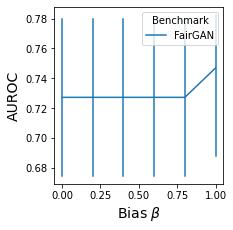

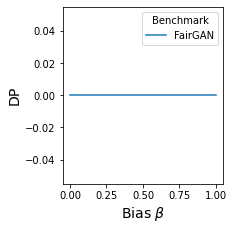

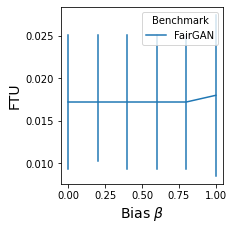

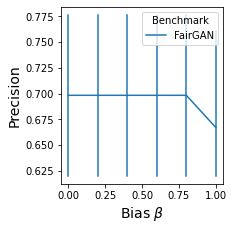

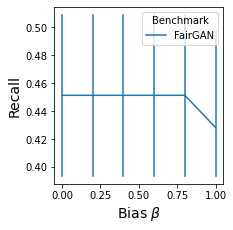

In [13]:
import os, glob
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
path = 'logs' # use your path
all_files = glob.glob(path + "/*.log")

li = []


methods = ['Benchmark', 'bias', 'precision', 'recall', 'density', 'coverage', 'dp', 'ftu', 'auc']



def read_df(filename):
    df = pd.read_csv(filename, index_col=False, header=0, names = methods)
    df['ftu'] = abs(df['ftu'])
    df['dp'] = abs(df['dp'])
    df.loc[df.Benchmark == 'fairgan', 'Benchmark'] = 'FairGAN'
    df.loc[df.Benchmark == 'DECAF', 'Benchmark'] = 'DECAF-ND'
    df = df[df.Benchmark != 'adsgan']
    
    df = df[df.Benchmark != 'adsgan-pr']
    df = df[df.Benchmark != 'gan']
    df = df[df.Benchmark != 'gan-pr']
    df = df[df.Benchmark != 'wgan']
    df = df[df.Benchmark != 'wgan-pr']
    df.bias = 1 - df.bias
    return df


def read_df2(filename):
    df = pd.read_csv(filename, index_col=False, header=0, names = methods)
    df['ftu'] = abs(df['ftu'])
    df['dp'] = df['dp'] - np.min(df['dp'])
    df.loc[df.Benchmark == 'fairgan', 'Benchmark'] = 'FairGAN'
    df.loc[df.Benchmark == 'DECAF', 'Benchmark'] = 'DECAF-ND'
    df = df[df.Benchmark != 'adsgan']
    
    df = df[df.Benchmark != 'adsgan-pr']
    df = df[df.Benchmark != 'gan']
    df = df[df.Benchmark != 'gan-pr']
    df = df[df.Benchmark != 'wgan']
    df = df[df.Benchmark != 'wgan-pr']
    df = df[df.Benchmark != 'FairGAN']

    return df


def read_df3(filename):
    df = pd.read_csv(filename, index_col=False, header=0, names = methods)
    df['ftu'] = abs(df['ftu'])
    df['dp'] = abs(df['dp'])
    df.loc[df.Benchmark == 'fairgan', 'Benchmark'] = 'FairGAN'
    df.loc[df.Benchmark == 'DECAF', 'Benchmark'] = 'DECAF-ND'
    df.loc[df.Benchmark == 'DECAF-FTU', 'Benchmark'] = 'DECAF-FTU1'
    df = df[df.Benchmark != 'adsgan']
    
    df = df[df.Benchmark != 'adsgan-pr']
    df = df[df.Benchmark != 'gan']
    df = df[df.Benchmark != 'gan-pr']
    df = df[df.Benchmark != 'wgan']
    df = df[df.Benchmark != 'wgan-pr']
    df = df[df.Benchmark != 'FairGAN']
    df.bias = 1 - df.bias
    return df

import seaborn as sns

df = read_df('plots_surrogate_confounder_both.csv')
dims = (3.3,3.3)
plt.figure(figsize = dims)

fig = sns.lineplot(data=df, x='bias', y = 'auc', hue = 'Benchmark', err_style = "bars")


plt.xlabel(r"Bias $\beta$", fontsize=14)
plt.ylabel("AUROC", fontsize=14)
plt.tight_layout()
plt.savefig('fig_auroc2.pdf')

plt.figure(figsize = dims)
sns.lineplot(data=df, x='bias', y = 'dp', hue = 'Benchmark',err_style="bars")
plt.xlabel(r"Bias $\beta$", fontsize=14)
plt.ylabel("DP", fontsize=14)
plt.tight_layout()
plt.savefig('fig_dp2.pdf')


plt.figure(figsize = dims)
sns.lineplot(data=df, x='bias', y = 'ftu', hue = 'Benchmark', err_style="bars")
plt.xlabel(r"Bias $\beta$", fontsize=14)
plt.ylabel("FTU", fontsize=14)
plt.tight_layout()
plt.savefig('fig_ftu2.pdf')

plt.figure(figsize = dims)
sns.lineplot(data=df, x='bias', y = 'precision', hue = 'Benchmark',err_style="bars")
plt.xlabel(r"Bias $\beta$", fontsize=14)
plt.ylabel("Precision", fontsize=14)
plt.tight_layout()
plt.savefig('fig_prec2.pdf')


plt.figure(figsize = dims)
sns.lineplot(data=df, x='bias', y = 'recall', hue = 'Benchmark',err_style="bars" )
plt.xlabel(r"Bias $\beta$", fontsize=14)
plt.ylabel("Recall", fontsize=14)
plt.tight_layout()
plt.savefig('fig_recall2.pdf')